In [22]:
import pandas as pd
from rake_nltk import Rake
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel

# load the data

In [23]:
df3=pd.read_csv(r'C:\Users\onfon\Desktop\recommender system\clean1_data.csv')
df3.head(3)

,Unnamed: 0,Movie Id,Title (Credit),Cast,Crew,Budget,Genres,Homepage,Id,Keywords,...,Release Date,Revenue,Runtime,Spoken Languages,Status,Tagline,Title,Vote Average,Vote Count,Director
0,0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"['Action', 'Adventure', 'Fantasy']",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war']",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,James Cameron
1,1,285,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,285,"['ocean', 'drug abuse', 'exotic island']",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Gore Verbinski
2,2,206647,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,206647,"['spy', 'based on novel', 'secret agent']",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Sam Mendes


# Demographic Filtering

In [6]:
#mean vote across the whole report
C= df3['Vote Average'].mean()
#mean rating
m= df3['Vote Count'].quantile(0.9)
#filter movie that qualify
q_movies=df3.copy().loc[df3['Vote Count']>=m]
#calculate the metric for qualified movies
def weighted_rating(x,m=m,C=C):
    V=x['Vote Count']
    R=x['Vote Average']
    #calculation based on imdb formula
    return(V/(V+m)*R)+(m/(m+V)*C)
#define a new feature 'score' & calculate its value
q_movies['score']=q_movies.apply(weighted_rating,axis=1)
#sort movies based on scores calculated
q_movies=q_movies.sort_values('score',ascending=False)
#print the top 5 movies
q_movies[['Title','Vote Count','Vote Average','score']].head(5)


,Title,Vote Count,Vote Average,score
1873,The Shawshank Redemption,8205,8.5,8.064300
655,Fight Club,9413,8.3,7.943487
65,The Dark Knight,12002,8.2,7.923423
3223,Pulp Fiction,8428,8.3,7.909197
96,Inception,13752,8.1,7.866167


Text(0.5, 1.0, 'Popular Movies')

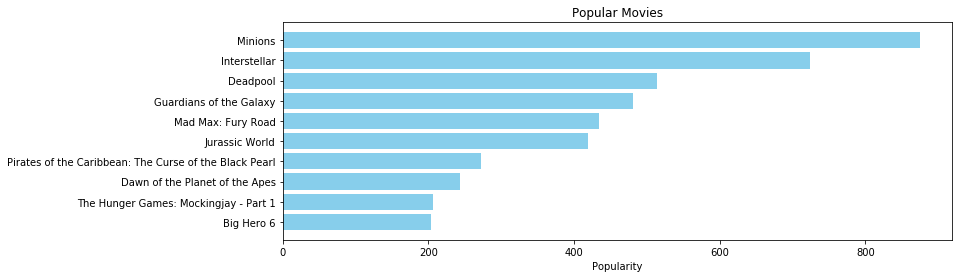

In [7]:
pop= df3.sort_values('Popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['Title'].head(10),pop['Popularity'].head(10), align='center',color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# Content based filtering

In [44]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
# Apply clean_data function to the features.
features = ['Cast', 'Keywords', 'Director', 'Genres','Production Companies','Production Countries','Overview','Tagline']
for feature in features:
    df3[feature] = df3[feature].apply(clean_data)


        

In [52]:
#selecting relevant  columns 
df4 = df3[['Title','Cast', 'Keywords', 'Director', 'Genres','Production Companies','Production Countries','Overview','Tagline']]
df4.head()

,Title,Cast,Keywords,Director,Genres,Production Companies,Production Countries,Overview,Tagline
0,Avatar,"['samworthington','zoesaldana','sigourneyweaver']","['cultureclash','future','spacewar']",jamescameron,"['action','adventure','fantasy']","['ingeniousfilmpartners','twentiethcenturyfoxf...","['unitedstatesofamerica','unitedkingdom']","inthe22ndcentury,aparaplegicmarineisdispatched...",entertheworldofpandora.
1,Pirates of the Caribbean: At World's End,"['johnnydepp','orlandobloom','keiraknightley']","['ocean','drugabuse','exoticisland']",goreverbinski,"['adventure','fantasy','action']","['waltdisneypictures','jerrybruckheimerfilms',...",['unitedstatesofamerica'],"captainbarbossa,longbelievedtobedead,hascomeba...","attheendoftheworld,theadventurebegins."
2,Spectre,"['danielcraig','christophwaltz','léaseydoux']","['spy','basedonnovel','secretagent']",sammendes,"['action','adventure','crime']","['columbiapictures','danjaq','b24']","['unitedkingdom','unitedstatesofamerica']",acrypticmessagefrombondâ€™spastsendshimonatrai...,aplannooneescapes
3,The Dark Knight Rises,"['christianbale','michaelcaine','garyoldman']","['dccomics','crimefighter','terrorist']",christophernolan,"['action','crime','drama']","['legendarypictures','warnerbros.','dcentertai...",['unitedstatesofamerica'],"followingthedeathofdistrictattorneyharveydent,...",thelegendends
4,John Carter,"['taylorkitsch','lynncollins','samanthamorton']","['basedonnovel','mars','medallion']",andrewstanton,"['action','adventure','sciencefiction']",['waltdisneypictures'],['unitedstatesofamerica'],"johncarterisawar-weary,formermilitarycaptainwh...","lostinourworld,foundinanother."


In [53]:
#extracting key words
# initializing the new column
df4['Key_words'] = ""

for index, row in df4.iterrows():
    content = row['Overview']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(content)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

df4.drop(columns = ['Overview'], inplace = True)

C:\Users\onfon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
df4[['Key_words']].head(5)

,Key_words
0,[aparaplegicmarineisdispatchedtothemoonpandora...
1,"[longbelievedtobedead, butnothingisquiteasitse..."
2,[bondpeelsbackthelayersofdeceittorevealtheterr...
3,"[batmanassumesresponsibilityfordent, anewterro..."
4,"[saworldonthebrinkofcollapse, formermilitaryca..."


In [55]:
from ast import literal_eval

def literal_eval_cust(x):
    try:
        return literal_eval(x)
    except Exception:
        return {}

features =  ['Cast', 'Keywords', 'Genres','Production Companies','Production Countries']
for feature in features:
    df4[feature] = df4[feature].apply(literal_eval_cust)


C:\Users\onfon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [58]:
df5=df4

# merging column words

In [60]:

for index, row in df5.iterrows():
    row['Cast'] = ''.join(row['Cast']).lower()
    row['Keywords'] = ''.join(row['Keywords']).lower()
    row['Director'] = ''.join(row['Director']).lower()
    row['Genres'] = ''.join(row['Genres']).lower()
    row['Production Companies'] = ''.join(row['Production Companies']).lower()
    row['Production Countries'] = ''.join(row['Production Countries']).lower()
    row['Tagline'] = ''.join(row['Tagline']).lower()
    

In [61]:
df5.head(3)

,Title,Cast,Keywords,Director,Genres,Production Companies,Production Countries,Tagline,Key_words
0,Avatar,samworthingtonzoesaldanasigourneyweaver,cultureclashfuturespacewar,jamescameron,actionadventurefantasy,ingeniousfilmpartnerstwentiethcenturyfoxfilmco...,unitedstatesofamericaunitedkingdom,entertheworldofpandora.,[aparaplegicmarineisdispatchedtothemoonpandora...
1,Pirates of the Caribbean: At World's End,johnnydepporlandobloomkeiraknightley,oceandrugabuseexoticisland,goreverbinski,adventurefantasyaction,waltdisneypicturesjerrybruckheimerfilmssecondm...,unitedstatesofamerica,"attheendoftheworld,theadventurebegins.","[longbelievedtobedead, butnothingisquiteasitse..."
2,Spectre,danielcraigchristophwaltzléaseydoux,spybasedonnovelsecretagent,sammendes,actionadventurecrime,columbiapicturesdanjaqb24,unitedkingdomunitedstatesofamerica,aplannooneescapes,[bondpeelsbackthelayersofdeceittorevealtheterr...


In [62]:
#set title as the index 
df5.set_index('Title', inplace = True)


# creating bag of words

In [63]:

df5['bag_of_words'] = ''
columns = df5.columns
for index, row in df5.iterrows():
    words = ''
    for col in columns:
        if col != 'Cast':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
df5.drop(columns = [col for col in df5.columns if col!= 'bag_of_words'], inplace = True)

C:\Users\onfon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
df5.head(3)

,bag_of_words
Title,
Avatar,samworthingtonzoesaldanasigourneyweaver c u l ...
Pirates of the Caribbean: At World's End,johnnydepporlandobloomkeiraknightley o c e a n...
Spectre,danielcraigchristophwaltzléaseydoux s p y b a ...


In [65]:
df5.to_csv('bag_of_words.csv')

# CountVectorizer() instead of TF-IDF.

In [66]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df5['bag_of_words'])


In [67]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [68]:
# Reset index of our main DataFrame 
df5 = df5.reset_index()
indices = pd.Series(df5.index, index=df5['Title'])

In [73]:
#ignore
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

In [70]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(Title, cosine_sim2=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices[Title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim2[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df5['Title'].iloc[movie_indices]

In [76]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

0                                       Avatar
1     Pirates of the Caribbean: At World's End
2                                      Spectre
4                                  John Carter
5                                 Spider-Man 3
6                                      Tangled
7                      Avengers: Age of Ultron
8       Harry Potter and the Half-Blood Prince
9           Batman v Superman: Dawn of Justice
10                            Superman Returns
Name: Title, dtype: object

In [ ]:
!pip install azureml.opendatasets
from azureml.opendatasets import NycTlcGreen
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta